<a href="https://colab.research.google.com/github/SGhuman123/Data-Science-Portfolio/blob/main/Udemy%20TensorFlow%20Developer%20Certificate%20Bootcamp/Section%208%20Introduction%20to%20NLP/08_Exercise_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 08. Introduction to NLP (Natural Language Processing) in TensorFlow Exercises

1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the Keras Sequential API instead of the Functional API.
2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?

3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer

```
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model

```

4. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the `sample_submission.csv` file from Kaggle (see the Files tab in Colab for what the `sample_submission.csv` file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?

5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?

6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

## Check for GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-8d68d622-6e55-7b1a-1f4a-35761e69812d)


## Get helper functions

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-17 16:49:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-17 16:49:56 (64.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functios for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data

## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

See the original source here: https://www.kaggle.com/competitions/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip the data
unzip_data("nlp_getting_started.zip")

--2024-01-17 16:50:07--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.207, 74.125.128.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  1.30MB/s    in 0.4s    

2024-01-17 16:50:08 (1.30 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/
But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
# train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
# train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like?
# test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,  # use 10% of training data for validation split
                                                                            random_state=42)

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVctorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # How many words in the vocabulary (automatically add <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be?
                                    pad_to_max_tokens=True)

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split(" ")) for i in train_sentences]) / len(train_sentences))

15

In [ ]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how mant words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# # Choose a random sentence from the training dataset and tokenize it
# random_sentence = random.choice(train_sentences)
# print(f"Original text:\n {random_sentence}\
#         \n\nVectorized text:\n {text_vectorizer(random_sentence)}")

Original text:
 #Obama signed up to a deal that far from making the world a safer place http://t.co/E0luGBL6pb via @upi #Iran #Nuclear #IranNuclearDeal        

Vectorized text:
 [ 213 1592   27    5    3  711   16  685   20  572    2  107    3 2724
  596]


In [ ]:
# # Get the unique words in the vocabulary
# words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
# top_5_words = words_in_vocab[:5] # get the most common words
# bottom_5_words = words_in_vocab[-5:] # get the least common words
# print(f"Number of words in vocab: {len(words_in_vocab)}")
# print(f"5 most common words: {top_5_words}")
# print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
# train_sentences

### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128,
                             embeddings_initializer="uniform",
                            #  input_length=max_vocab_length # how long is each input
                             input_length=max_length # how long is each input
                             )

embedding

In [ ]:
# # Get a random sentence from the training set
# random_sentence = random.choice(train_sentences)
# print(f"Original text:\n {random_sentence}\n\nEmbedded version:")

# # Embed the random sentence (turn it into dense vectors of fixed size)
# sample_embed = embedding(text_vectorizer([random_sentence]))
# sample_embed

Original text:
 @__ScrambledEggs calling it now: KIA gets banned or quarantined before month's end

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03923817, -0.03035125,  0.03152324, ..., -0.02640375,
         -0.01683604, -0.04929641],
        [-0.03375316, -0.0035872 ,  0.04942161, ...,  0.04488714,
          0.03951781,  0.04726638],
        [-0.0014649 , -0.01410218,  0.00322527, ..., -0.00579191,
          0.0190458 , -0.0498121 ],
        ...,
        [-0.00495953, -0.01632289, -0.0456224 , ..., -0.04820181,
         -0.04123215,  0.03091634],
        [-0.00495953, -0.01632289, -0.0456224 , ..., -0.04820181,
         -0.04123215,  0.03091634],
        [-0.00495953, -0.01632289, -0.0456224 , ..., -0.04820181,
         -0.04123215,  0.03091634]]], dtype=float32)>

In [ ]:
# # Check out a single token's embedding
# sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.03923817, -0.03035125,  0.03152324, -0.01191775,  0.00972538,
        -0.04817547,  0.01042217, -0.04722896, -0.01674419, -0.01209193,
        -0.01931466, -0.01080806,  0.0123369 ,  0.03112917, -0.03659924,
         0.04951668, -0.02520968,  0.033595  , -0.0035539 , -0.01495453,
         0.01532272, -0.04942736,  0.03525467,  0.00416886,  0.03671343,
        -0.04479369,  0.01288063, -0.04084091, -0.01728608, -0.0183046 ,
        -0.04305481, -0.02493359,  0.02931041,  0.04871447,  0.02182499,
        -0.00072838, -0.00173918,  0.01929215, -0.01524507,  0.01854812,
        -0.00909983,  0.01537413, -0.03195767,  0.00497859, -0.04763481,
        -0.00035963, -0.01919967,  0.00952759,  0.00468666, -0.01555934,
        -0.01234205, -0.01472163, -0.03465928, -0.02133908, -0.02349917,
        -0.03308996, -0.04113178, -0.00517067, -0.018748  , -0.02113906,
        -0.01565859,  0.02478942,  0.01303292, -0.02009377, -0.00923407,
  

## 1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) instead of the Functional API.

## Modeling a text dataset

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling exmperiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)

How are we going to approach all of these?

Use the standard steps in modelling with TensorFlow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> Note: It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
                    ])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# # Build model with Functional API
# from tensorflow.keras import layers
# inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional string
# x = text_vectorizer(inputs) # turn the inputs text into numbers
# x = embedding(x) # create an embedding of the numberized inputs
# x = layers.GlobalAveragePooling1D(name="global_avg_pool_layer")(x) # condense the feature vector for each token to one vector
# outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoid activation function
# model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
# Build model with Keras Sequential API
from tensorflow.keras import layers
model_1 = tf.keras.models.Sequential(name="model_1_dense")
model_1.add(tf.keras.Input(shape=(1,), dtype=tf.string)) # inputs are 1-dimensional string
model_1.add(text_vectorizer) # turn the inputs text into numbers
model_1.add(embedding) # create an embedding of the numberized inputs
model_1.add(layers.GlobalAveragePooling1D(name="global_avg_pool_layer")) # condense the feature vector for each token to one vector
model_1.add(layers.Dense(1, activation="sigmoid")) # Create the output layer, want binary outputs so use sigmoid activation function

model_1.summary()

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240117-165016
Epoch 1/5
215/215 [==============================] - 10s 38ms/step - loss: 0.6119 - accuracy: 0.6942 - val_loss: 0.5386 - val_accuracy: 0.7467
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4421 - accuracy: 0.8189 - val_loss: 0.4705 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3474 - accuracy: 0.8596 - val_loss: 0.4658 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2857 - accuracy: 0.8891 - val_loss: 0.4738 - val_accuracy: 0.7940
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2386 - accuracy: 0.9118 - val_loss: 0.4786 - val_accuracy: 0.7822


In [ ]:
# Model is not performing as well as baseline
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4786 - accuracy: 0.7822


[0.4786360561847687, 0.7821522355079651]

In [ ]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 3ms/step


(762, 1)

In [ ]:
# look at a single prediction
# model_1_pred_probs[0]

array([0.40087605], dtype=float32)

In [ ]:
# look at the first 10 prediction
# model_1_pred_probs[:10]

array([[0.40087605],
       [0.7733729 ],
       [0.99702805],
       [0.09752329],
       [0.14699998],
       [0.9402357 ],
       [0.9127731 ],
       [0.9929554 ],
       [0.96666604],
       [0.23096174]], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.21522309711287,
 'precision': 0.7853104900348995,
 'recall': 0.7821522309711286,
 'f1': 0.7796592181651525}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [ ]:
# # Get the vocabulary from the text vectorization layer
# words_in_vocab = text_vectorizer.get_vocabulary()
# len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_avg_pool_layer (Glo  (None, 128)               0         
 balAveragePooling1D)                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Get the weight matrix of embedding layer
# (these are the numerical representations of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [ ]:
# embed_weights

In [ ]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# # Download files from Colab to upload to projector
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

Downloading the files above we can visualize using https://projector.tensorflow.org/ and clicking the "load" button on the left hand side.

Resources: If you'd like to know more about embeddings, I'd encourage you to check out:
* Jay Alammar's visualizd word2vec post: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embeddings guide: https://www.tensorflow.org/text/guide/word_embeddings

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> Resources: If you want an overview of the internals of a recurrent neural network, see the following:
- MIT's sequence modelling lecture https://www.youtube.com/watch?v=ySEx_Bqxvvo
- Chris Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Andrej Karpathy's the unreasonable effectiveness of neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:
```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [ ]:
# Create an LSTM
from tensorflow.keras import layers
model_2 = tf.keras.models.Sequential(name="model_2_LSTM")
model_2.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model_2.add(text_vectorizer)
model_2.add(embedding)
model_2.add(layers.LSTM(64))
model_2.add(layers.Dense(1, activation="sigmoid"))

In [ ]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240117-165036
Epoch 1/5
215/215 [==============================] - 11s 35ms/step - loss: 0.2200 - accuracy: 0.9210 - val_loss: 0.5617 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1547 - accuracy: 0.9429 - val_loss: 0.6450 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1256 - accuracy: 0.9524 - val_loss: 0.8112 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1041 - accuracy: 0.9603 - val_loss: 0.7969 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0845 - accuracy: 0.9664 - val_loss: 1.0006 - val_accuracy: 0.7769


In [ ]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[3.6646817e-03],
       [7.1812022e-01],
       [9.9986577e-01],
       [7.6768599e-02],
       [5.3696817e-04],
       [9.9910551e-01],
       [9.6166772e-01],
       [9.9989295e-01],
       [9.9982661e-01],
       [8.3477193e-01]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 0.7784265812728361,
 'recall': 0.7769028871391076,
 'f1': 0.7750036673315875}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Convolution Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typcially 2D (height x width)... however, our text data is 1D.

Previously we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)
* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # this is also referred to an ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1, # default
                        activation="relu",
                        padding="same") # default = "valid", the output is smaller than the input shape, "same" means output is same shape as input
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [ ]:
# embedding_test

In [ ]:
# conv_1d_output

In [ ]:
# max_pool_output

In [ ]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
model_5 = tf.keras.models.Sequential(name="model_5_Conv1D")
model_5.add(tf.keras.Input(shape=(1,), dtype="string"))
model_5.add(text_vectorizer)
model_5.add(embedding)
model_5.add(layers.Conv1D(filters=64,
                          kernel_size=5,
                          strides=1,
                          activation="relu",
                          padding="same"))
model_5.add(layers.GlobalMaxPool1D())
model_5.add(layers.Dense(1, activation="sigmoid"))

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

# get a summary of our Conv1D mode
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1321089 (5.04 MB)
Trainable params: 13

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240117-165100
Epoch 1/5
215/215 [==============================] - 10s 38ms/step - loss: 0.1433 - accuracy: 0.9531 - val_loss: 0.8293 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0974 - accuracy: 0.9651 - val_loss: 0.8758 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0765 - accuracy: 0.9724 - val_loss: 0.9625 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0642 - accuracy: 0.9734 - val_loss: 1.0380 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0583 - accuracy: 0.9774 - val_loss: 1.0941 - val_accuracy: 0.7717


In [ ]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[1.2991515e-01],
       [5.5607533e-01],
       [9.9996412e-01],
       [2.3028707e-02],
       [3.2413241e-06],
       [9.9024314e-01],
       [7.7713519e-01],
       [9.9981707e-01],
       [9.9999344e-01],
       [9.5429194e-01]], dtype=float32)

In [ ]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.16535433070865,
 'precision': 0.7726063176824562,
 'recall': 0.7716535433070866,
 'f1': 0.7699532001851459}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## 2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?

In [ ]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
# len(train_labels_10_percent)

In [ ]:
# Check the number of each label in the updated training data subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [ ]:
# len(train_df_shuffled)

In [ ]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how th USE was created here: https://arxiv.org/abs/1803.11175

### Model USE 10%: Universal Sentence Encoder model with 10% of the training data?


In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you can the universial sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346 -0.04209305  0.0267898   0.03011008  0.00321069
 -0.00337971 -0.04787356  0.02266719 -0.00985925 -0.04063613 -0.01292093
 -0.04666384  0.056303   -0.03949255  0.00517688  0.02495828 -0.07014441
  0.02871508  0.04947684 -0.00633978 -0.08960193  0.02807117 -0.00808362
 -0.01360601  0.0599865  -0.10361787 -0.05195374  0.00232955 -0.0233253
 -0.03758105  0.03327729], shape=(50,), dtype=float32)


In [ ]:
embed_samples[0].shape

TensorShape([512])

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_USE_10_percent = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_USE_10_percent")

# Compile
model_USE_10_percent.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_USE_10_percent.summary()

Model: "model_USE_10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit the model to the 10% training data subsets
model_USE_10_percent_history = model_USE_10_percent.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20240117-165202
Epoch 1/5
22/22 [==============================] - 4s 50ms/step - loss: 0.6679 - accuracy: 0.6993 - val_loss: 0.6442 - val_accuracy: 0.7690
Epoch 2/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5959 - accuracy: 0.8102 - val_loss: 0.5876 - val_accuracy: 0.7743
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5203 - accuracy: 0.8117 - val_loss: 0.5337 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4584 - accuracy: 0.8190 - val_loss: 0.5005 - val_accuracy: 0.7848
Epoch 5/5
22/22 [==============================] - 1s 29ms/step - loss: 0.4204 - accuracy: 0.8292 - val_loss: 0.4875 - val_accuracy: 0.7953


In [ ]:
# Make predictions with the model trained on 10% of the data
model_USE_10_percent_pred_probs = model_USE_10_percent.predict(val_sentences)
model_USE_10_percent_pred_probs[:10]

24/24 [==============================] - 1s 11ms/step


array([[0.20651388],
       [0.6192202 ],
       [0.9280269 ],
       [0.36534804],
       [0.5196142 ],
       [0.6843436 ],
       [0.8871291 ],
       [0.82328993],
       [0.86177975],
       [0.15610541]], dtype=float32)

In [ ]:
# Turn pred probs into labels
model_USE_10_percent_preds = tf.squeeze(tf.round(model_USE_10_percent_pred_probs))
model_USE_10_percent_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate model_USE_10_percent predictions
model_USE_10_percent_results = calculate_results(y_true=val_labels,
                                    y_pred=model_USE_10_percent_preds)
model_USE_10_percent_results

{'accuracy': 79.52755905511812,
 'precision': 0.7964863637691877,
 'recall': 0.7952755905511811,
 'f1': 0.7938557395327305}

### Model baseline 10%: baseline model with 10% of the training data

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_baseline_10_percent = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
                    ])

# Fit the pipeline to the training data
model_baseline_10_percent.fit(train_sentences_10_percent, train_labels_10_percent)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_10_percent_score = model_baseline_10_percent.score(val_sentences, val_labels)
print(f"Our baseline model with 10% of training data achieves an accuracy of: {baseline_10_percent_score*100:.2f}%")

Our baseline model with 10% of training data achieves an accuracy of: 70.21%


In [ ]:
# Make predictions
baseline_10_percent_preds = model_baseline_10_percent.predict(val_sentences)
baseline_10_percent_preds[:20]

array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Get baseline results
baseline_10_percent_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_10_percent_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
model_USE_10_percent_results

{'accuracy': 79.52755905511812,
 'precision': 0.7964863637691877,
 'recall': 0.7952755905511811,
 'f1': 0.7938557395327305}

## 3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer.

>

```
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True, # turn training on to fine-tune the TensorFlow Hub model
                                        name="USE_set_trainable_true")

In [ ]:
# Create model using the Sequential API
model_USE_10_percent_trainable_true = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_USE_10_percent_trainable_true")

# Compile
model_USE_10_percent_trainable_true.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_USE_10_percent_trainable_true.summary()

Model: "model_USE_10_percent_trainable_true"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_set_trainable_true (Ke  (None, 512)               256797824 
 rasLayer)                                                       
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 256830721 (979.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fit the model to the 10% training data subsets
model_USE_10_percent_trainable_true_history = model_USE_10_percent_trainable_true.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_trainable_true_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_trainable_true_correct_split/20240117-165215
Epoch 1/5
22/22 [==============================] - 78s 2s/step - loss: 0.6093 - accuracy: 0.6861 - val_loss: 0.5986 - val_accuracy: 0.6785
Epoch 2/5
22/22 [==============================] - 19s 848ms/step - loss: 0.4387 - accuracy: 0.8131 - val_loss: 0.4975 - val_accuracy: 0.7927
Epoch 3/5
22/22 [==============================] - 12s 567ms/step - loss: 0.2341 - accuracy: 0.9299 - val_loss: 0.5253 - val_accuracy: 0.7480
Epoch 4/5
22/22 [==============================] - 8s 362ms/step - loss: 0.0994 - accuracy: 0.9737 - val_loss: 0.5683 - val_accuracy: 0.7717
Epoch 5/5
22/22 [==============================] - 6s 270ms/step - loss: 0.0372 - accuracy: 0.9942 - val_loss: 0.6812 - val_accuracy: 0.7388


In [ ]:
# Make predictions with the model trained on 10% of the data
model_USE_10_percent_trainable_true_pred_probs = model_USE_10_percent_trainable_true.predict(val_sentences)
model_USE_10_percent_trainable_true_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.07883546],
       [0.53546494],
       [0.9913652 ],
       [0.45987543],
       [0.9693973 ],
       [0.9177957 ],
       [0.98916537],
       [0.9881379 ],
       [0.9902952 ],
       [0.09262113]], dtype=float32)

In [ ]:
# Turn pred probs into labels
model_USE_10_percent_trainable_true_preds = tf.squeeze(tf.round(model_USE_10_percent_trainable_true_pred_probs))
model_USE_10_percent_trainable_true_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate model_USE_10_percent predictions
model_USE_10_percent_trainable_true_results = calculate_results(y_true=val_labels,
                                    y_pred=model_USE_10_percent_trainable_true_preds)
model_USE_10_percent_trainable_true_results

{'accuracy': 73.88451443569554,
 'precision': 0.7416482939632546,
 'recall': 0.7388451443569554,
 'f1': 0.7393199935047049}

##4. Retrain the best model you've got so far on the whole training set (no validation split).
Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the `sample_submission.csv` file from Kaggle (see the Files tab in Colab for what the `sample_submission.csv` file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?

### Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "5_conv1d": model_5_results,
                                  "USE_10%": model_USE_10_percent_results,
                                  "baseline_10%": baseline_10_percent_results,
                                  "USE_10%_true": model_USE_10_percent_trainable_true_results})
all_model_results = all_model_results.transpose()
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.782152,0.785310,0.782152,0.779659
2_lstm,0.776903,0.778427,0.776903,0.775004
5_conv1d,0.771654,0.772606,0.771654,0.769953
USE_10%,0.795276,0.796486,0.795276,0.793856
baseline_10%,0.792651,0.811139,0.792651,0.786219
USE_10%_true,0.738845,0.741648,0.738845,0.739320


## 5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?

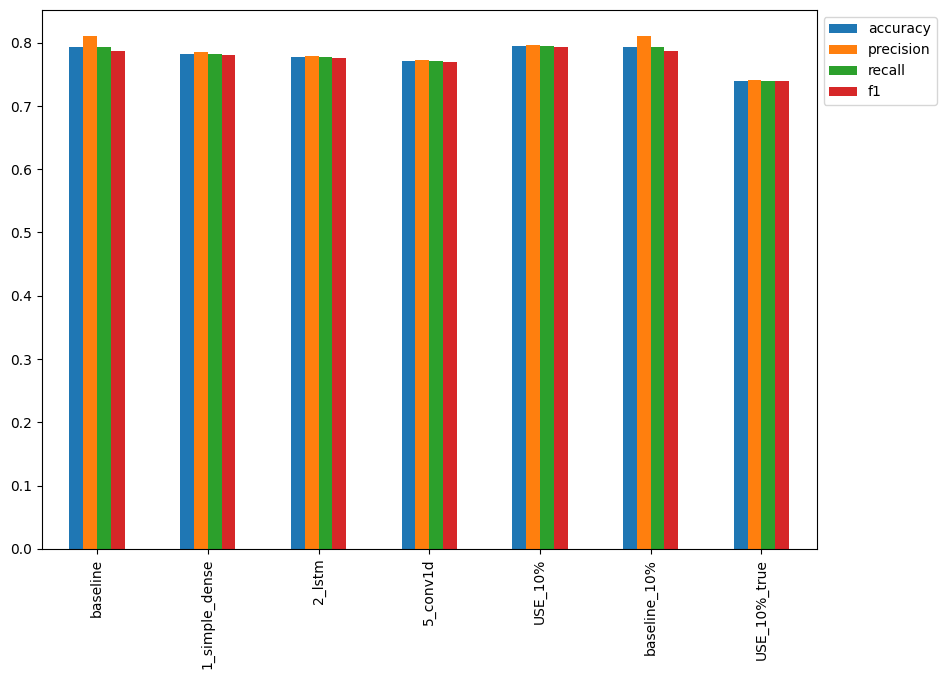

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

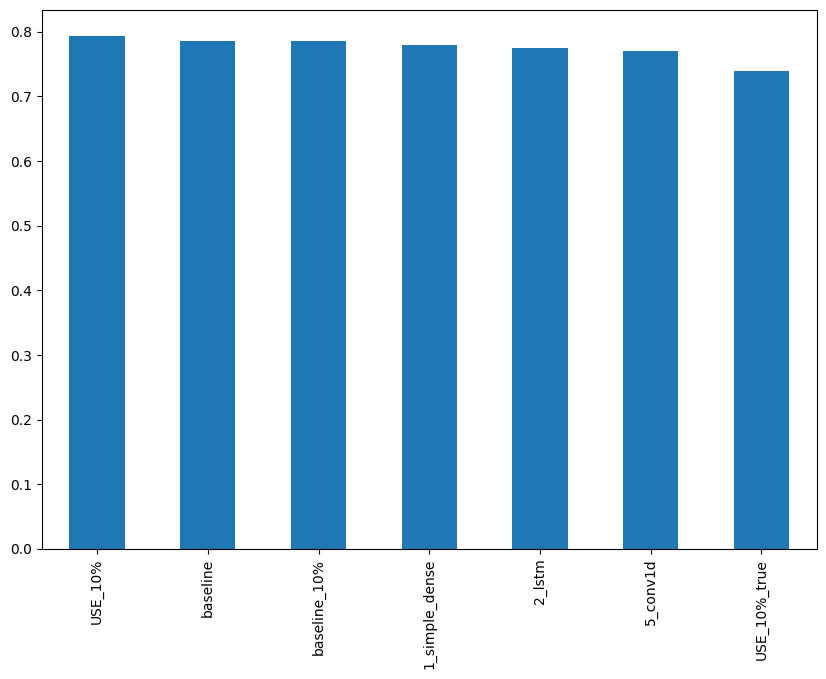

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values(by="f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Hence, we can conclude that the best model is baseline model as it has the highest F1-score.But let us train the USE_true model on 100% of the dataset.

## Potential ideas:
* Try trainable = False of 100% of the data
* Change the optimizer type try: RMSprop?
* Find the ideal learning rate? Use learning rate callback?
* Batching

* [Augment the data](https://neptune.ai/blog/data-augmentation-nlp) (hardest to do)

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True, # turn training on to fine-tune the TensorFlow Hub model
                                        name="USE_set_trainable_true_100")

In [ ]:
# Create model using the Sequential API
model_USE_trainable_true = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")], name="model_USE_trainable_true")

# Compile
model_USE_trainable_true.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_USE_trainable_true.summary()

Model: "model_USE_trainable_true"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_set_trainable_true_100  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 256830721 (979.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fit the model to the 10% training data subsets
model_USE_trainable_true_history = model_USE_trainable_true.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_trainable_true_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_trainable_true_correct_split/20240117-165426
Epoch 1/5
215/215 [==============================] - 122s 441ms/step - loss: 0.4462 - accuracy: 0.8025 - val_loss: 0.4227 - val_accuracy: 0.8281
Epoch 2/5
215/215 [==============================] - 23s 106ms/step - loss: 0.2265 - accuracy: 0.9145 - val_loss: 0.4857 - val_accuracy: 0.8150
Epoch 3/5
215/215 [==============================] - 18s 82ms/step - loss: 0.0748 - accuracy: 0.9750 - val_loss: 0.5513 - val_accuracy: 0.7992
Epoch 4/5
215/215 [==============================] - 18s 84ms/step - loss: 0.0392 - accuracy: 0.9870 - val_loss: 0.5830 - val_accuracy: 0.8084
Epoch 5/5
215/215 [==============================] - 16s 73ms/step - loss: 0.0252 - accuracy: 0.9901 - val_loss: 0.7160 - val_accuracy: 0.8084


In [ ]:
# Make predictions with the model trained on 100% of the data
model_USE_trainable_true_pred_probs = model_USE_trainable_true.predict(val_sentences)
model_USE_trainable_true_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.00927008],
       [0.937604  ],
       [0.99945265],
       [0.00412679],
       [0.5142727 ],
       [0.9944402 ],
       [0.99833244],
       [0.9994006 ],
       [0.9985838 ],
       [0.00507174]], dtype=float32)

In [ ]:
# Turn pred probs into labels
model_USE_trainable_true_preds = tf.squeeze(tf.round(model_USE_trainable_true_pred_probs))
model_USE_trainable_true_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate model_USE_trainable_true predictions
model_USE_trainable_true_results = calculate_results(y_true=val_labels,
                                    y_pred=model_USE_trainable_true_preds)
model_USE_trainable_true_results

{'accuracy': 80.83989501312337,
 'precision': 0.8201864993955552,
 'recall': 0.8083989501312336,
 'f1': 0.8042373179924797}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "5_conv1d": model_5_results,
                                  "USE_10%": model_USE_10_percent_results,
                                  "baseline_10%": baseline_10_percent_results,
                                  "USE_10%_true": model_USE_10_percent_trainable_true_results,
                                  "USE_100%_true": model_USE_trainable_true_results})
all_model_results = all_model_results.transpose()
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.782152,0.785310,0.782152,0.779659
2_lstm,0.776903,0.778427,0.776903,0.775004
5_conv1d,0.771654,0.772606,0.771654,0.769953
USE_10%,0.795276,0.796486,0.795276,0.793856
baseline_10%,0.792651,0.811139,0.792651,0.786219
USE_10%_true,0.738845,0.741648,0.738845,0.739320
USE_100%_true,0.808399,0.820186,0.808399,0.804237


In [ ]:
type(val_sentences)

numpy.ndarray

In [ ]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


#### Now let us test the USE_true model on 100% of the dataset on the test dataset.

In [ ]:
test_df["text"]

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

In [ ]:
type(test_df["text"])

pandas.core.series.Series

In [ ]:
test_sentences = test_df["text"].to_numpy()
test_sentences[:5]

array(['Just happened a terrible car crash',
       'Heard about #earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
       'Apocalypse lighting. #Spokane #wildfires',
       'Typhoon Soudelor kills 28 in China and Taiwan'], dtype=object)

In [ ]:
# Use trained baseline model to make predictions on the test dataset
# Make predictions
model_USE_trainable_true_probs = model_USE_trainable_true.predict(test_sentences)
model_USE_trainable_true_probs[:20]

102/102 [==============================] - 1s 10ms/step


array([[9.7380108e-01],
       [9.7358763e-01],
       [9.9884832e-01],
       [9.9752885e-01],
       [9.9893647e-01],
       [9.5483541e-01],
       [4.1908678e-03],
       [9.4245753e-04],
       [8.9804071e-04],
       [1.0166987e-03],
       [3.6101239e-03],
       [2.9467144e-03],
       [9.5544278e-04],
       [1.2511612e-03],
       [9.7587192e-04],
       [9.1660953e-01],
       [4.1994493e-02],
       [3.9143008e-01],
       [8.2706264e-04],
       [4.2318952e-01]], dtype=float32)

In [ ]:
# Convert model prediction probabilities to label format
model_USE_trainable_true_preds = np.array(model_USE_trainable_true_probs)
model_USE_trainable_true_preds = np.round(model_USE_trainable_true_preds).astype(int)
model_USE_trainable_true_preds = [j[0] for j in model_USE_trainable_true_preds]
model_USE_trainable_true_preds[:20]

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [ ]:
len(model_USE_trainable_true_preds)

3263

In [ ]:
test_df["id"].to_numpy()

array([    0,     2,     3, ..., 10868, 10874, 10875])

In [ ]:
# format the predictions into the same format as the sample_submission.csv file from Kaggle
# (see the Files tab in Colab for what the sample_submission.csv file looks like)
import pandas as pd
data = {"id": test_df["id"].to_numpy(),
        "target": model_USE_trainable_true_preds}
prediction_df = pd.DataFrame(data)
prediction_df.to_csv("submission.csv", index=False)

## 6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

In [ ]:
# Getting the model predictions

def give_preds(model, test_sentences):
  '''
  This model takes a model and the test sentences as input.
  Returns the prediction array of [0,1.....]
  '''
  pred_probs = model.predict(test_sentences)
  preds = tf.squeeze(tf.round(pred_probs))
  preds = tf.cast(preds , dtype = tf.int32)

  return preds

In [ ]:

# Funtion taken from the course
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [ ]:

# Predictions on the validation sentences
val_preds = give_preds(model_USE_trainable_true , val_sentences)

# Creating a array of our class names
class_names = ['not_a_disaster' , 'disaster']

# Checking the preds and true labels shape
val_preds.shape , val_labels.shape

24/24 [==============================] - 0s 10ms/step


(TensorShape([762]), (762,))

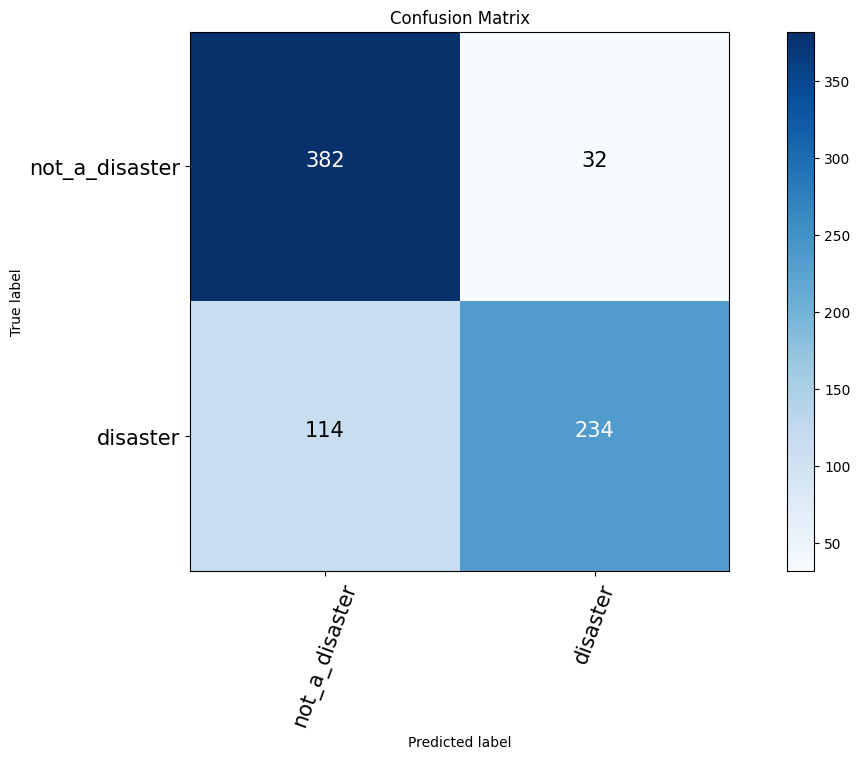

In [ ]:

# Plotting the confusion matrix
make_confusion_matrix(y_true= val_labels ,
                      y_pred = val_preds ,
                      classes = class_names ,
                      figsize= (15 , 7),
                      norm = False ,
                      savefig = True ,
                      text_size = 15)